# Dataset exploration

In this notebook the exploration required for task 3 will be described.

In [1]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import csv
from pyarrow import dataset as ds
import os
import numpy as np
import pandas as pd


import dask_jobqueue
import dask
import dask.dataframe as dd
import time

from distributed import Client
from contextlib import suppress 
import platform

PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/"
CSV_PATH = "/d/hpc/projects/FRI/bigdata/data/NYTickets"
PARQUET_FILENAME = "entire_1.parquet"

files = os.listdir(CSV_PATH)
files = list([f for f in files if ".csv" in f])
files.sort()
print(files)

['2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv', '2020.csv', '2021.csv', '2022.csv']


In [2]:
with suppress(Exception):
    client.shutdown()

cluster = dask_jobqueue.SLURMCluster(
            queue = 'all', 
            processes=1,
            cores=32, 
            memory='8GB',
            scheduler_options={'dashboard_address': ':21722'},
            death_timeout=120, # seconds
            walltime="01:30:00",
          )

client = Client(cluster, timeout="120s")#, memory_limit='8GB')
display(client.cluster)

In [3]:
client.cluster.scale(32)
display(client.cluster)

In [17]:
client.shutdown()

In [8]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Issue Date', 'Vehicle Body Type', "Violation Location"])
df['Date']=dd.to_datetime(df['Issue Date'])
df['Weekday'] = df['Date'].dt.day_name()

CPU times: user 24.2 ms, sys: 65 µs, total: 24.3 ms
Wall time: 24.2 ms


## Basic exploration

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
%%time
df_weekday = df["Weekday"].value_counts()
df_weekday = df_weekday.to_frame("Violation Num.")
df_weekday["Weekday"] = df_weekday.index
df_weekday = df_weekday.reset_index()[["Weekday", "Violation Num."]]
df_c = df_weekday.compute()

CPU times: user 762 ms, sys: 119 ms, total: 880 ms
Wall time: 32.3 s


In [13]:
df_weekday

,Weekday,Violation Num.
npartitions=1,,
,object,int64
,...,...


<AxesSubplot:xlabel='Weekday', ylabel='Violation Num.'>

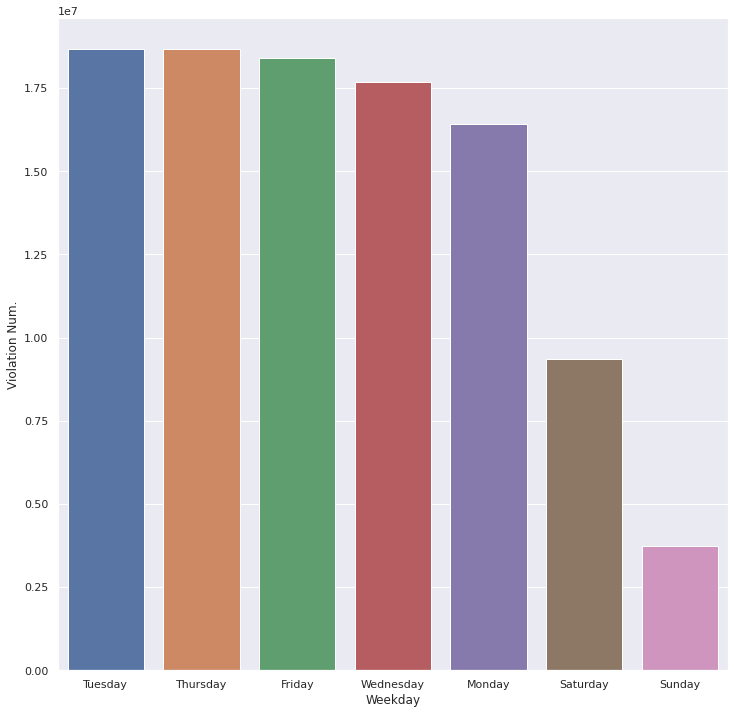

In [7]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='Weekday',y='Violation Num.')

In [22]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Vehicle Year'])
df_vehicle_body_type = df["Vehicle Year"].dropna().value_counts()
df_vehicle_body_type = df_vehicle_body_type.to_frame("Violation Num.")
df_vehicle_body_type["Vehicle Year"] = df_vehicle_body_type.index
df_vehicle_body_type = df_vehicle_body_type.reset_index()[["Vehicle Year", "Violation Num."]]
df_c = df_vehicle_body_type.compute().drop([0])

CPU times: user 179 ms, sys: 21.5 ms, total: 201 ms
Wall time: 4.16 s


<AxesSubplot:xlabel='Violation Num.', ylabel='Vehicle Year'>

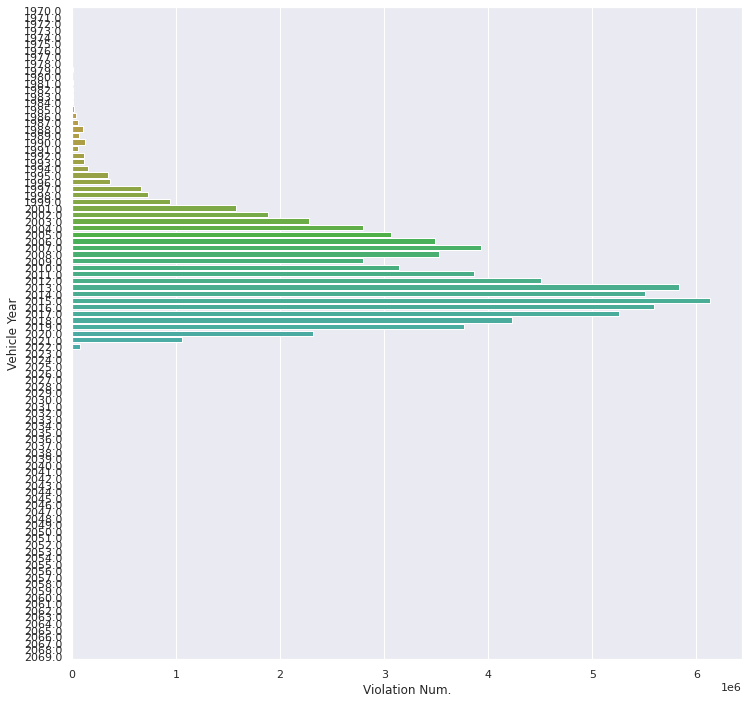

In [26]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,y ='Vehicle Year',x='Violation Num.',orient="h")

In [52]:
%%time
county_map = {'BX':'BRONX', 
                'BRONX':'BRONX',
                'MN':'MANHATTAN',
                'M':'MANHATTAN',
                'NY':'MANHATTAN',
                'MAN':'MANHATTAN',
                'NEWY':'MANHATTAN',
                'MH':'MANHATTAN',
                'NYC':'MANHATTAN',
                'NEW Y':'MANHATTAN',
                'BK':'BROOKLYN',
                'K':'BROOKLYN',
                'K F':'BROOKLYN',
                'KINGS':'BROOKLYN',
                'KING':'BROOKLYN',
                'Q':'QUEENS',
                'QU':'QUEENS',
                'QN':'QUEENS',
                'QNS':'QUEENS',
                'QUEEN':'QUEENS',
                'ST':'STATEN ISLAND',
                'R':'STATEN ISLAND',
                'RICH':'STATEN ISLAND',
                'P':'OTHER',
                '103':'OTHER',
                'RC':'OTHER',
                'QU':'QUEENS',
                '00000':'OTHER',
                'PBX':'OTHER',
                'USA':'OTHER',
                'K   F':'BROOKLYN',
                'A':'OTHER',
                'F':'OTHER',
                'Qns':'QUEENS',
                'Bronx':'BRONX',
                'Kings':'BROOKLYN',
                'Rich':'STATEN ISLAND',
                '': 'OTHER'

}
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Violation County'])
df['Violation County'] = df['Violation County'].fillna('P')
df[["County"]] = df[["Violation County"]].replace(to_replace= county_map)
#df.head(3)

df_violation_county = df['County'].value_counts()
df_violation_county = df_violation_county.to_frame("Violation Num.")
df_violation_county['County'] = df_violation_county.index
df_violation_county = df_violation_county.reset_index()[['County', "Violation Num."]]
df_c = df_violation_county.compute()
df_c.head(3)

ValueError: Metadata inference failed in `replace`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
ValueError('Series.replace cannot use dict-like to_replace and non-None value')

Traceback:
---------
  File "/cvmfs/sling.si/modules/el7/software/Anaconda3/2020.11/lib/python3.8/site-packages/dask/dataframe/utils.py", line 174, in raise_on_meta_error
    yield
  File "/cvmfs/sling.si/modules/el7/software/Anaconda3/2020.11/lib/python3.8/site-packages/dask/dataframe/core.py", line 5165, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/cvmfs/sling.si/modules/el7/software/Anaconda3/2020.11/lib/python3.8/site-packages/dask/utils.py", line 893, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/d/hpc/home/mf4782/.local/lib/python3.8/site-packages/pandas/core/frame.py", line 5282, in replace
    return super().replace(
  File "/d/hpc/home/mf4782/.local/lib/python3.8/site-packages/pandas/core/generic.py", line 6686, in replace
    return self._replace_columnwise(mapping, inplace, regex)
  File "/d/hpc/home/mf4782/.local/lib/python3.8/site-packages/pandas/core/frame.py", line 5317, in _replace_columnwise
    newobj = ser.replace(target, value, regex=regex)
  File "/d/hpc/home/mf4782/.local/lib/python3.8/site-packages/pandas/core/series.py", line 4960, in replace
    return super().replace(
  File "/d/hpc/home/mf4782/.local/lib/python3.8/site-packages/pandas/core/generic.py", line 6679, in replace
    raise ValueError(


<AxesSubplot:xlabel='County', ylabel='Violation Num.'>

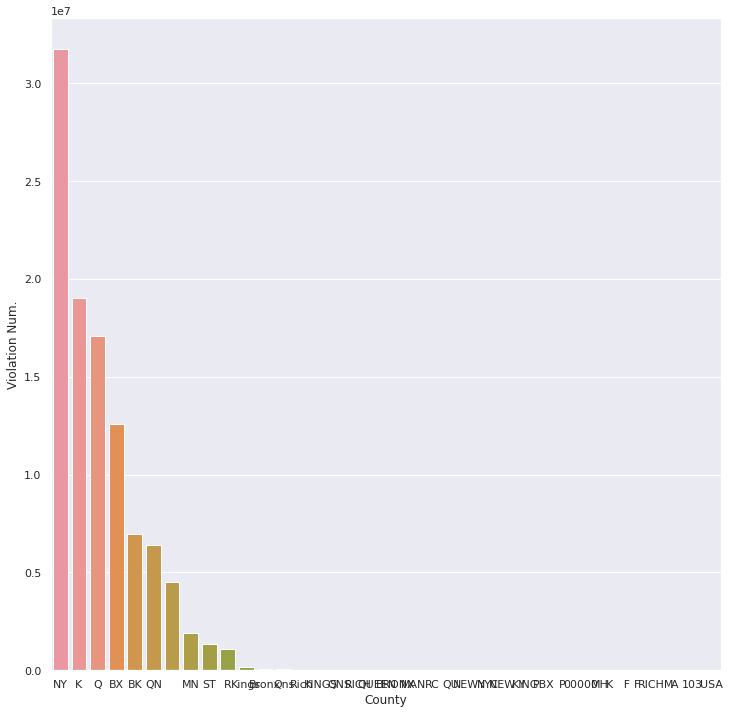

In [34]:
plt.figure(figsize=(12,12))
sns.barplot(data=df_c,x ='County',y='Violation Num.')

In [35]:
df_c.head(3)

,County,Violation Num.
0,NY,31761444
1,K,19018368
2,Q,17090640


In [53]:
!pip install plotly.express
!pip install plotly.io

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.2 MB 8.2 kB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io


In [54]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Registration State'])
df_violation_county = df['Registration State'].value_counts()
df_violation_county = df_violation_county.to_frame("Violation Num.")
df_violation_county['Registration State'] = df_violation_county.index
df_violation_county = df_violation_county.reset_index()[['Registration State', "Violation Num."]]
df_c = df_violation_county.compute()
df_c.head(3)

,Registration State,Violation Num.
0,NY,79465913
1,NJ,9363215
2,PA,2798648


In [57]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

fig = px.choropleth(df_c,
                    locations='Registration State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Violation Num.',
                    color_continuous_scale="Viridis_r"
                    )
fig.show()

In [80]:
%%time
df = dd.read_parquet(PATH + PARQUET_FILENAME, columns=['Violation County', 'Vehicle Year'])
df = df[df["Vehicle Year"] != 0]
df = df[df["Violation County"] != ""]
df["c"] = 1
df = df.groupby(['Violation County', 'Vehicle Year']).sum()
#df = df.compute()
#df['Violation County'] = list([df.index[i][0] for i in range(len(df.index))])
#df['Vehicle Year'] = list([df.index[i][1] for i in range(len(df.index))])
#df = df.reset_index()[['Registration State', "Violation Num."]]

df = df.reset_index()

df_c = df.compute()
df_c.head(3)

CPU times: user 369 ms, sys: 54.6 ms, total: 424 ms
Wall time: 11.2 s


,Violation County,Vehicle Year,c
0,00000,2021.0,1
1,BK,1970.0,81
2,BK,1971.0,100


<AxesSubplot:xlabel='Vehicle Year', ylabel='c'>

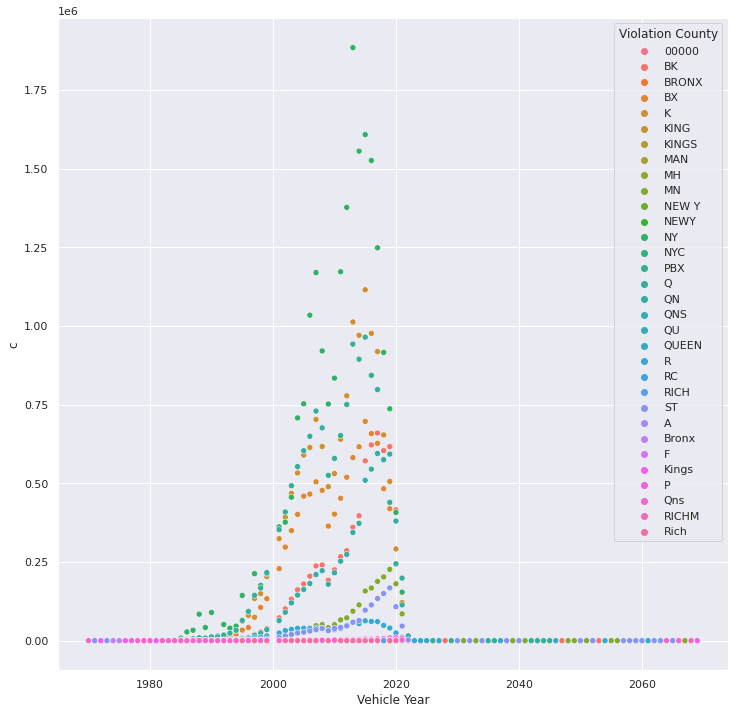

In [82]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=df_c, x='Vehicle Year', y="c", hue='Violation County')

In [78]:
df_c.columns

Index(['c'], dtype='object')

In [79]:
df_c.reset_index()

,Violation County,Vehicle Year,c
0,00000,2021.0,1
1,BK,1970.0,81
2,BK,1971.0,100
3,BK,1972.0,85
4,BK,1973.0,88
...,...,...,...
1026,ST,2052.0,12
1027,ST,2057.0,5
1028,ST,2059.0,1
1029,ST,2060.0,2
